In [1]:
import settings
from tqdm import tqdm
import json
import os
from process_sentinel2 import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Define variables

In [2]:
DATA_PATH = settings.data_path
DATE_FORMAT = '%Y-%m-%d'
START_DATE = '2016-12-21'
END_DATE = '2021-04-20'
MASK_PATH = "water_mask.json"

### Make instance of data generator

In [3]:
data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, DATA_PATH, skip_invalid=True)
len(data_generator)

KeyError: 'cloud level'

### Load sample day

In [4]:
#sample_day = DayData(os.path.join("sample_data", "2021-01-25"))

### Load water mask

In [6]:
sample_day = DayData(os.path.join("sample_data", "2021-01-25"))

mask_height, mask_width, _ = sample_day.rgb.shape
mask = Mask(MASK_PATH, mask_width, mask_height)
mask.reduce_mask()

print("Pixel count:", mask.get_pixel_count())

100%|██████████| 441288/441288 [00:10<00:00, 43167.95it/s]


Pixel count: 17963


### Display mask in sample day

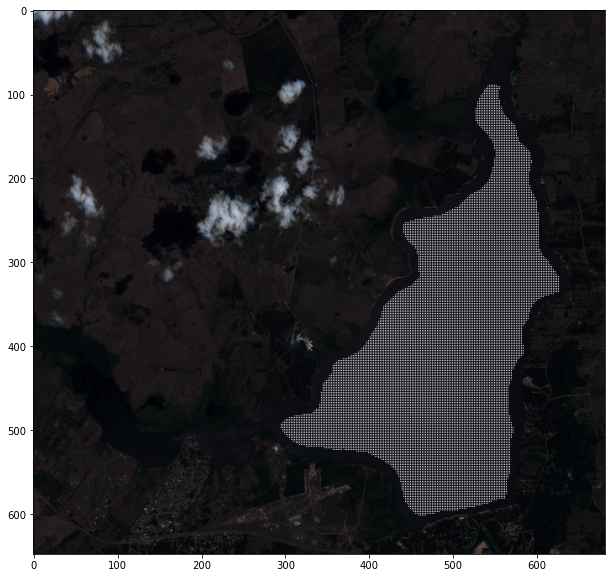

In [6]:
fig = plt.figure(figsize=(20,10))
plt.imshow(mask.display_mask_img(sample_day.rgb))
plt.show()

### Tag image cloudiness

levels of cloud:

0) Clear

1) minimum clouds over the lake

2) medium amount of clouds

3) too cloudy to be any good


2021-03-26 13:42:09
{'valid': False}


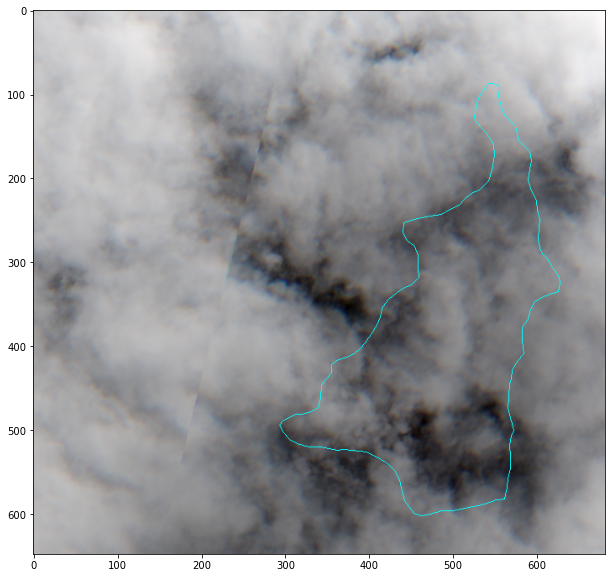

 3


In [7]:
from IPython.display import clear_output
import time

data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, DATA_PATH, tagging=True)

for day in data_generator:
    print(day.date)
    print(day.metadata)
    current_metadata = day.metadata
    #if current_metadata != {}:
        #time.sleep(0.1)
        #clear_output(wait=True)
        #continue
    # display rgb of day
    fig = plt.figure(figsize=(20,10))
    plt.imshow(mask.display_mask_contour(day.rgb))
    plt.show()
    # get user input
    user_input = input()
    # overwrite with changes
    with open(day.metadata_path, 'w') as fp:
        current_metadata["cloud level"] = user_input
        json.dump(current_metadata, fp)
    clear_output(wait=True)

## Clustering

### Make NDCI numpy array dataset

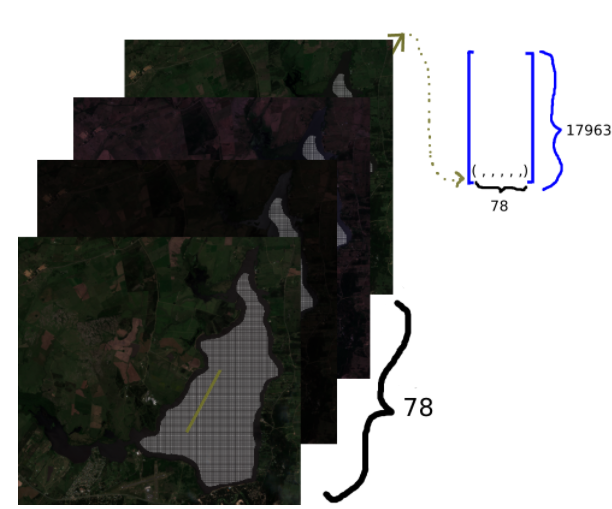

In [7]:
# make instance of data generator that skips invalid dates
data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, DATA_PATH, skip_invalid=True)
# make array to store ndci of every valid day
ndci_dataset_array = np.zeros((sample_day.rgb.shape[0], sample_day.rgb.shape[1], len(data_generator)))
H, W, D = ndci_dataset_array.shape
# list of dates for ndci_dataset_array
dates_list = []
# progress bar
pbar = tqdm(total=len(data_generator))
for d, day in enumerate(data_generator):
    ndci_day_array = day.get_NDCI()
    dates_list.append(str(day.date.date()))
    ndci_dataset_array[:, :, d] = ndci_day_array
    pbar.update(1)
pbar.close()

100%|██████████| 78/78 [00:02<00:00, 26.89it/s]


### Make clustering dataset

In [8]:
clustering_dataset = []
indexes = []
pbar = tqdm(total=mask.height*mask.width)
for i in range(mask.height):
    for j in range(mask.width):
        if mask.array[i, j] == 255:
            clustering_dataset.append(list(ndci_dataset_array[i, j, :]))
            indexes.append([i, j])
        pbar.update(1)
pbar.close()

100%|██████████| 441288/441288 [00:01<00:00, 333757.88it/s]


### Save to json

In [9]:
clustering_data = {}
clustering_data["data"] = clustering_dataset
clustering_data["positions"] = indexes
clustering_data["dates"] = dates_list

# with open("clustering_dataset_20m.json", 'w') as f:
#     json.dump(json_dictionary, f)

### Load clustering dataset

In [10]:
# import json

# with open("clustering_dataset_20m.json") as f:
#     clustering_data = json.load(f)

# Fit clustering data

In [10]:
X = clustering_data["data"]

### K-means

100%|██████████| 7/7 [00:35<00:00,  5.09s/it]


[2245.5147903640686, 1611.2322712941996, 1437.8284306211299, 1301.7525264294904, 1234.7436408914177, 1175.5968039708778, 1134.861932118631]


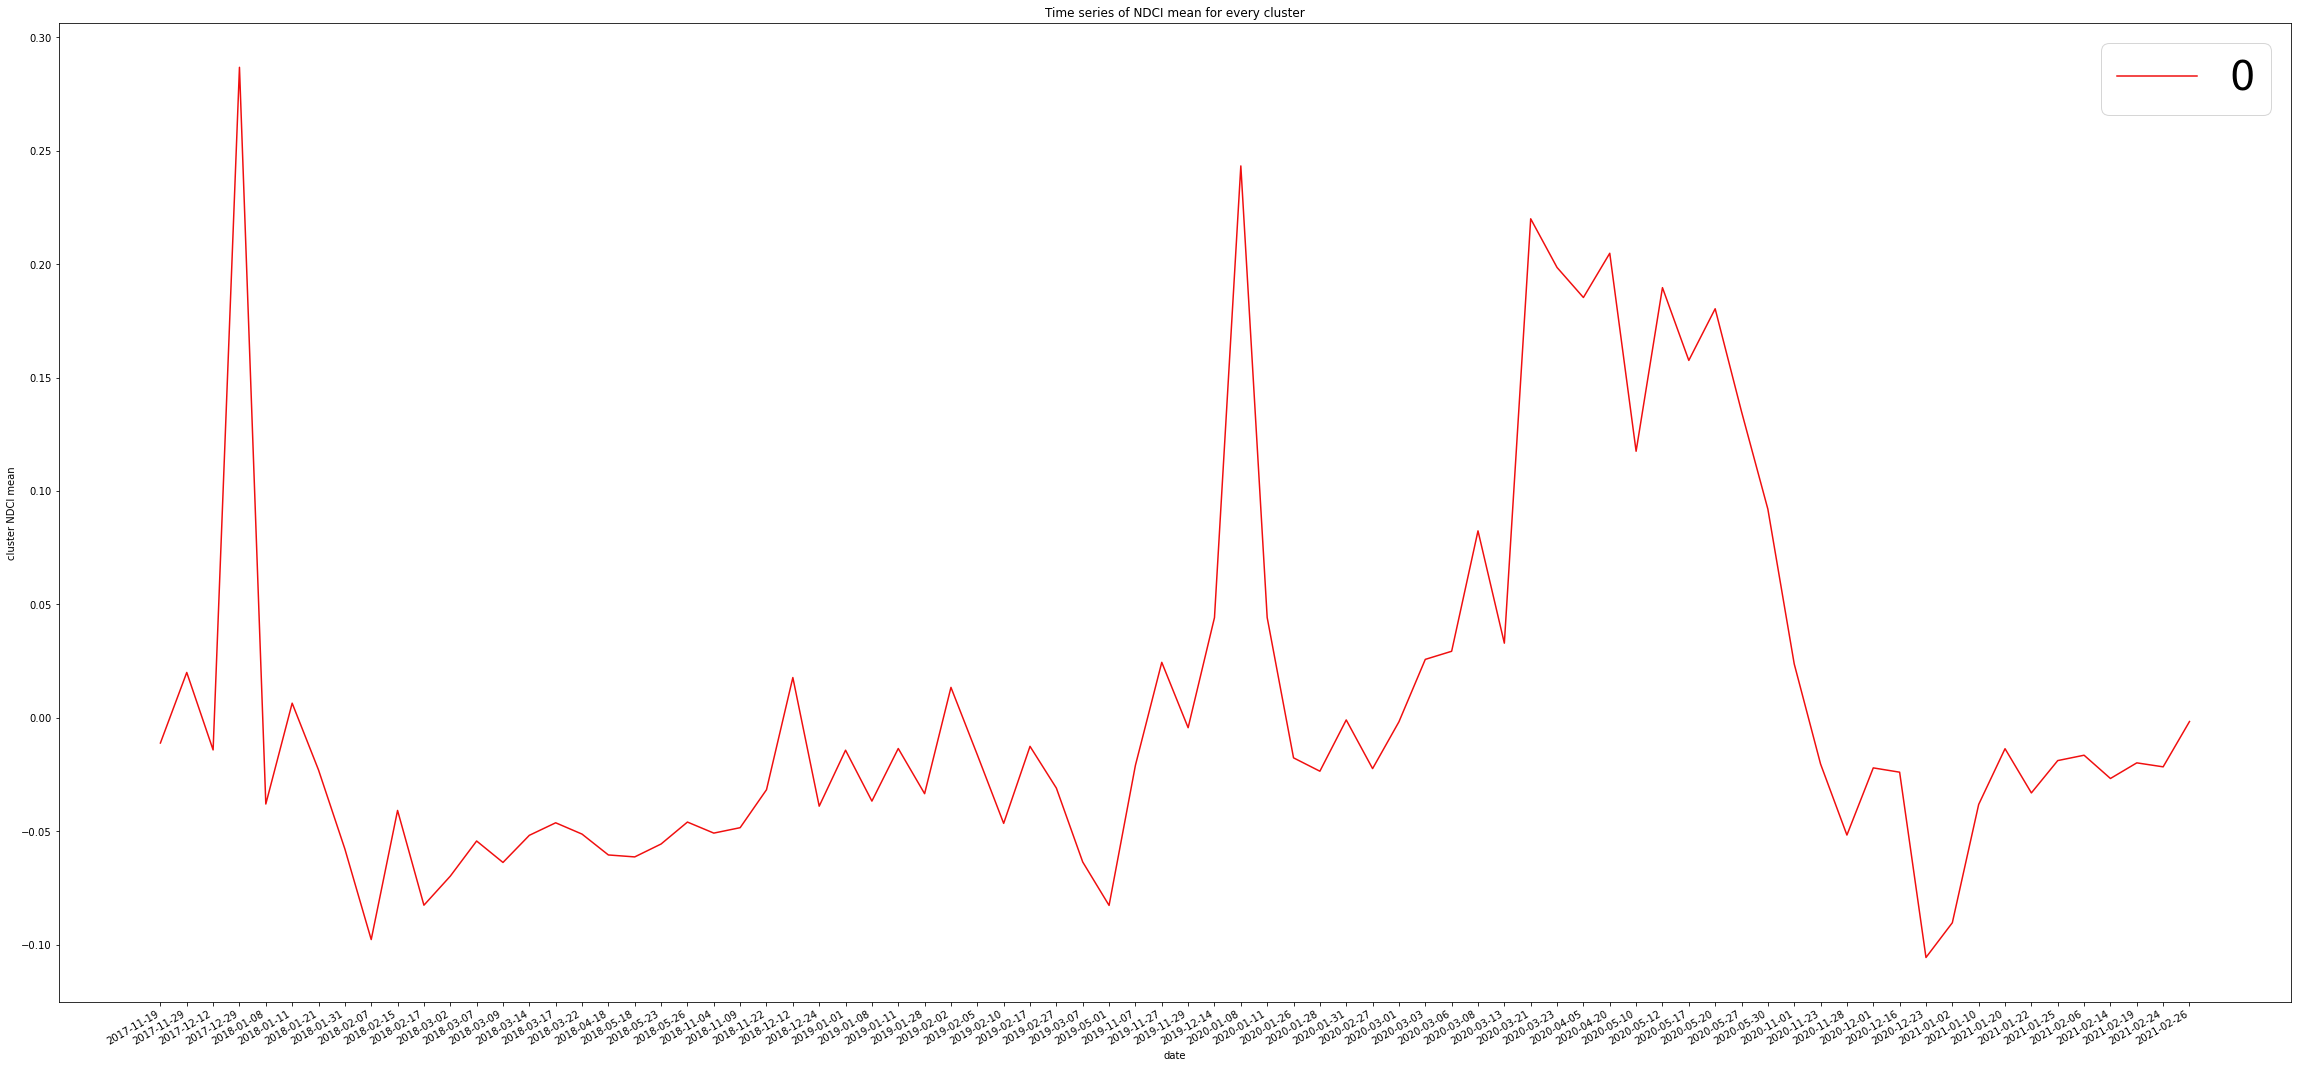

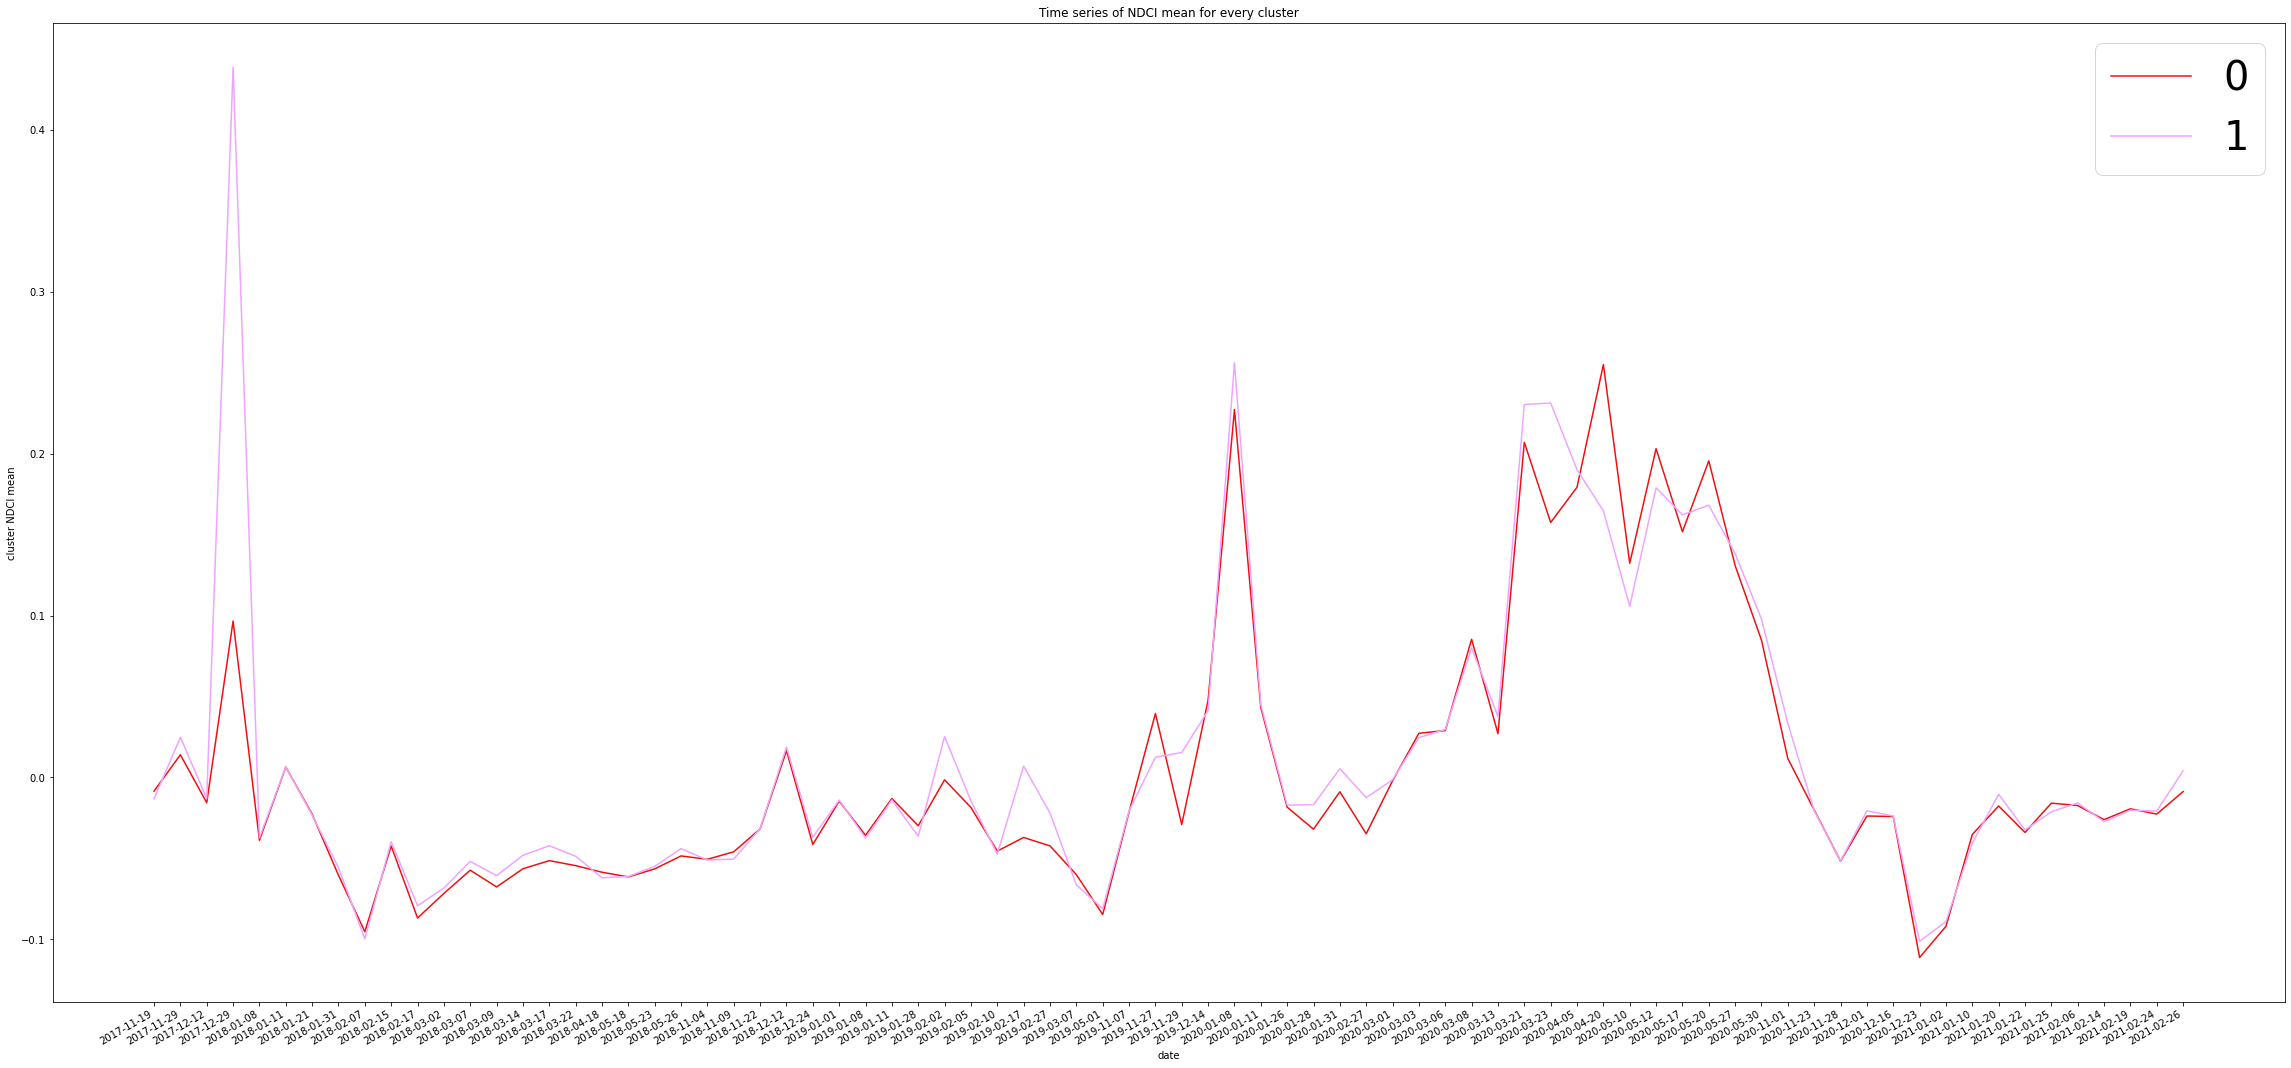

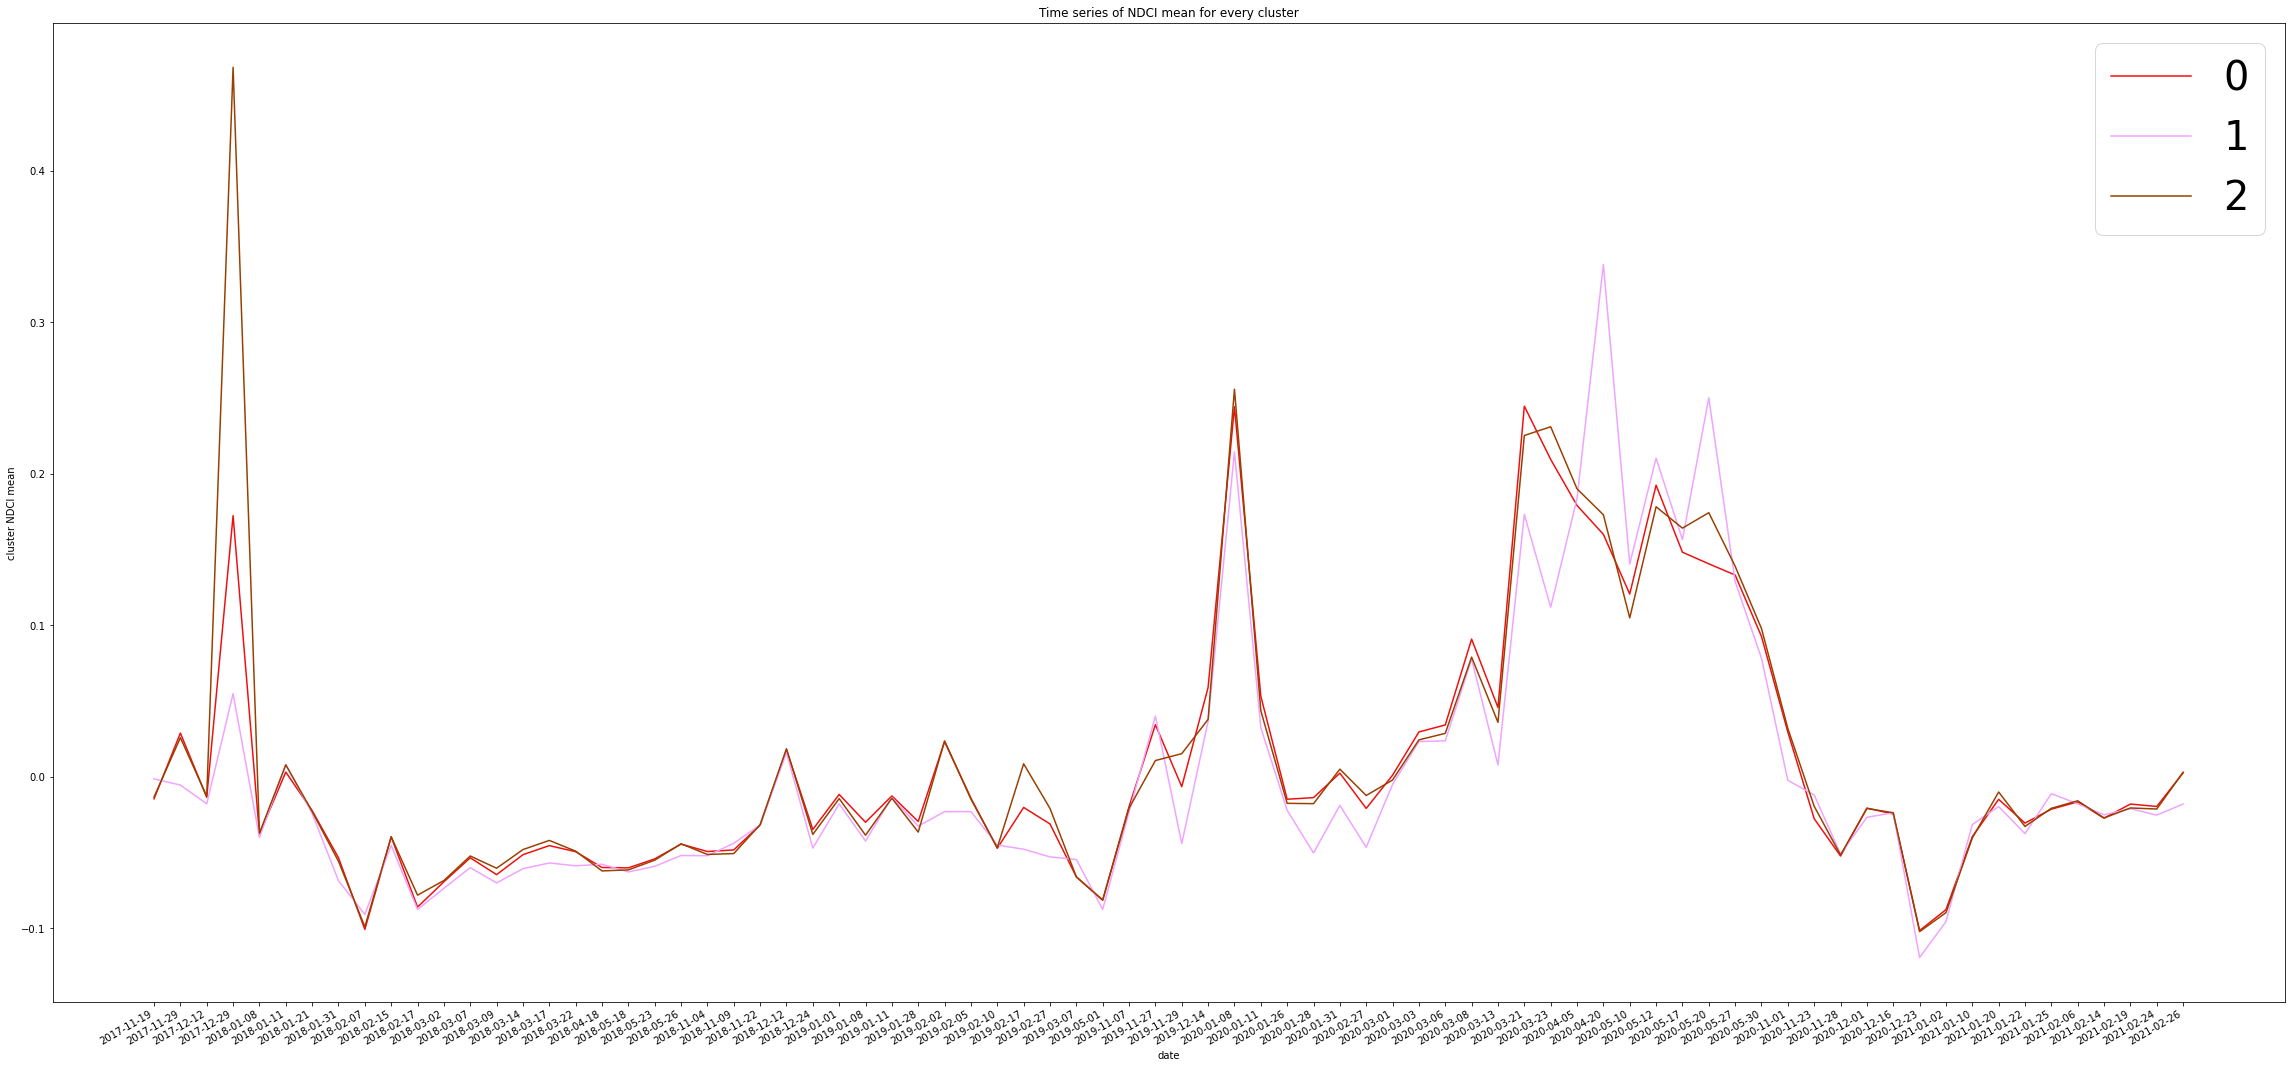

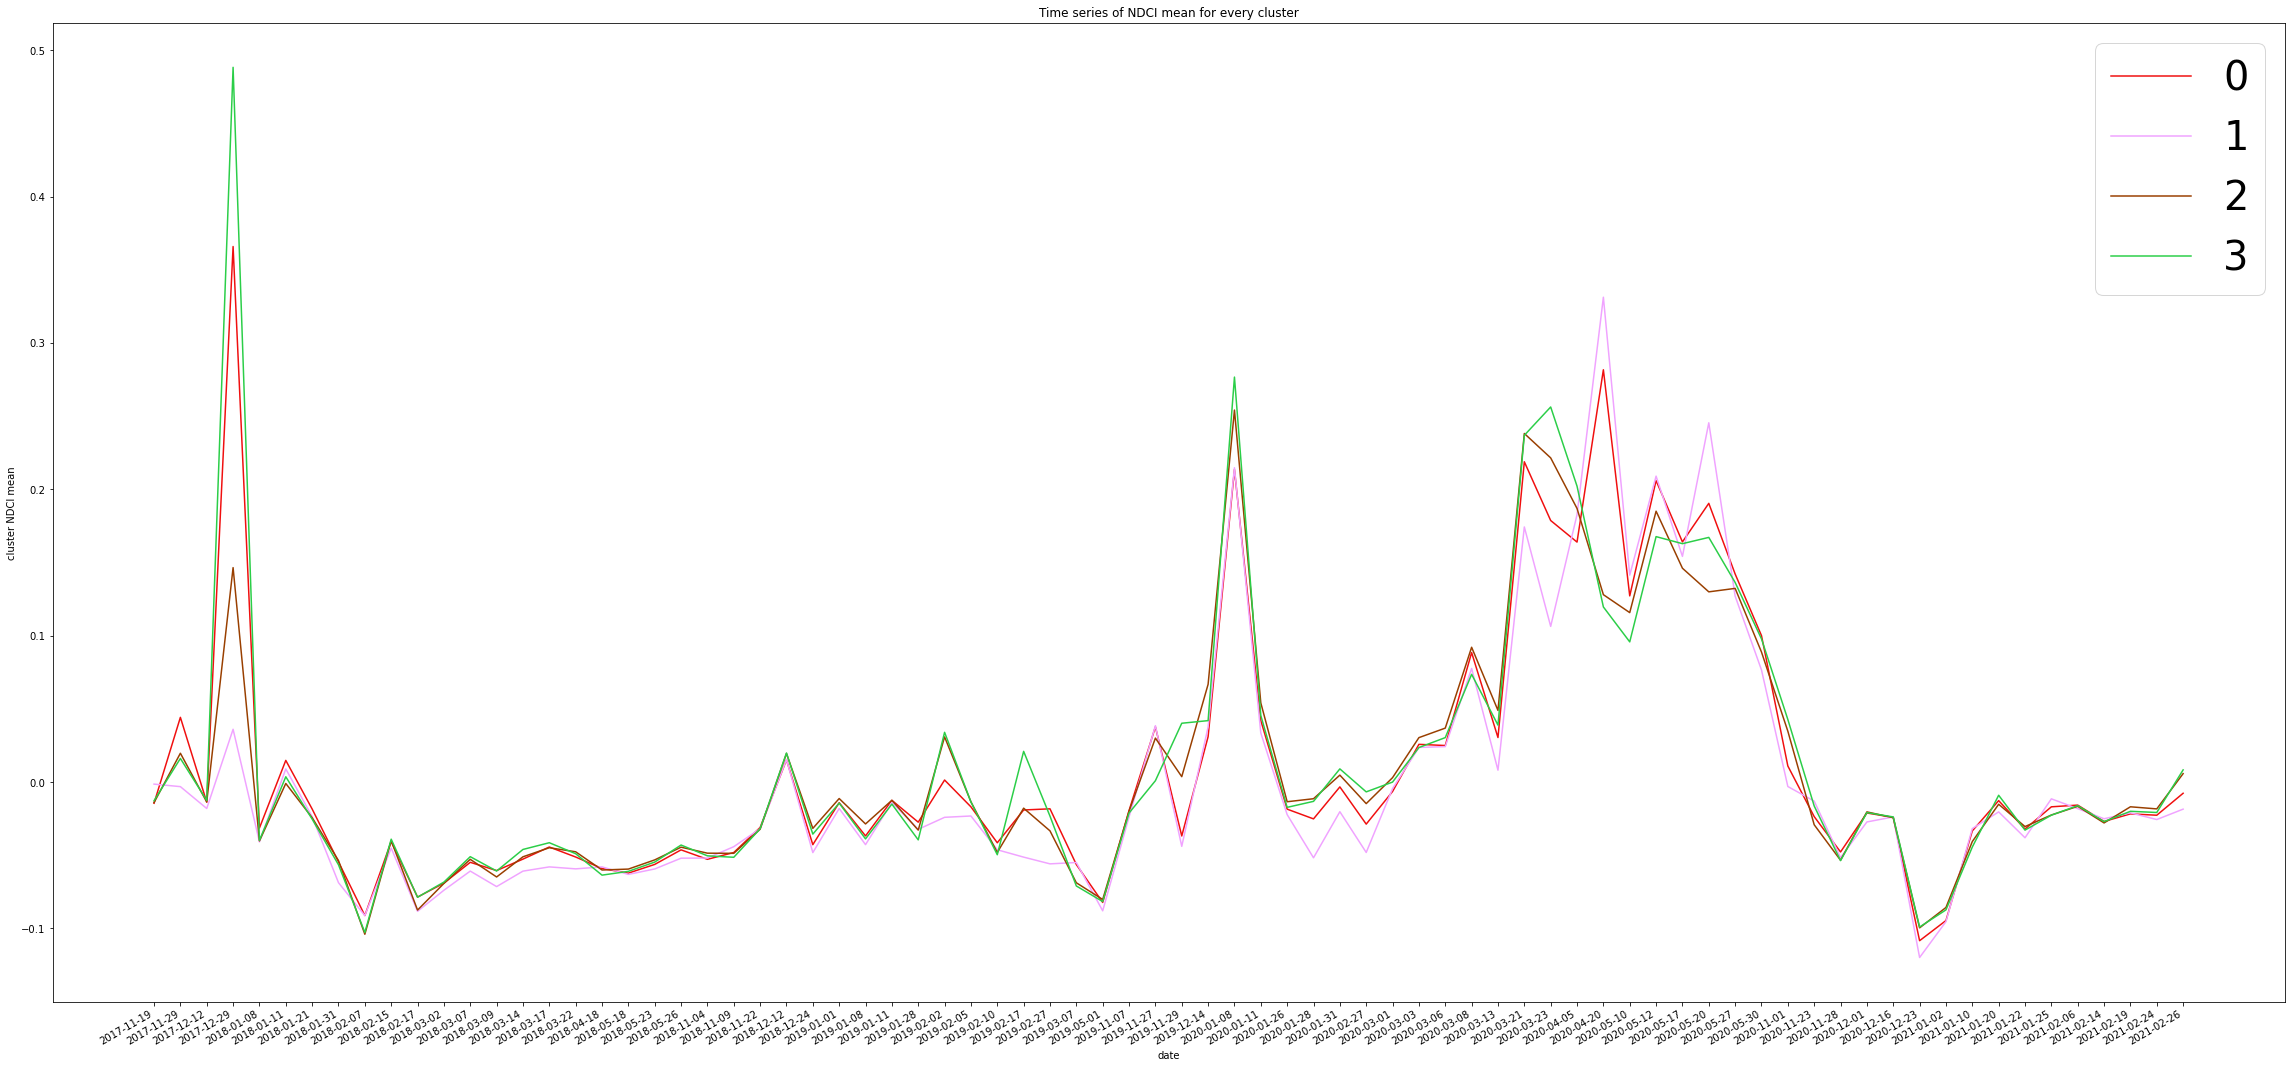

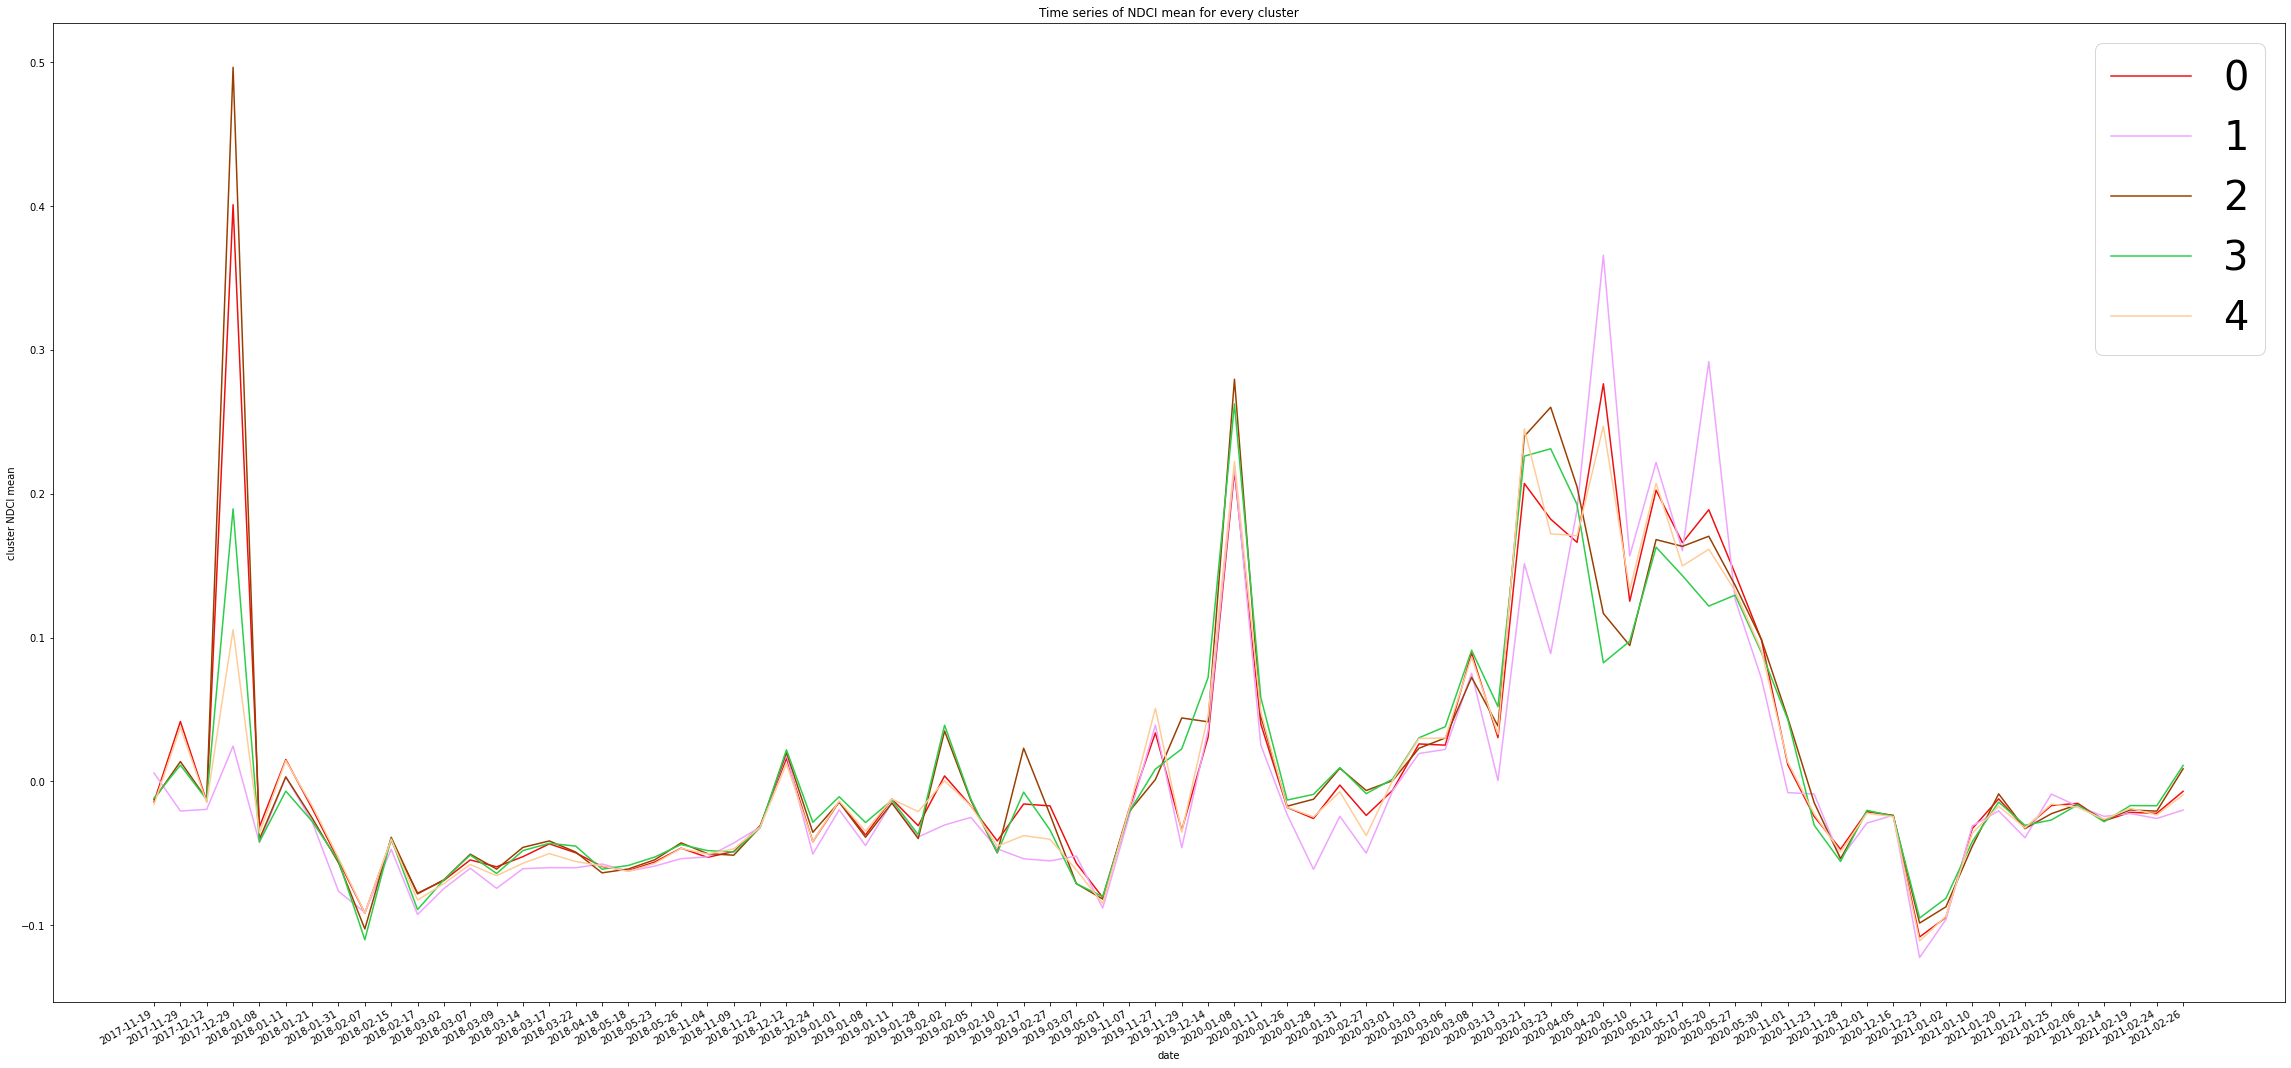

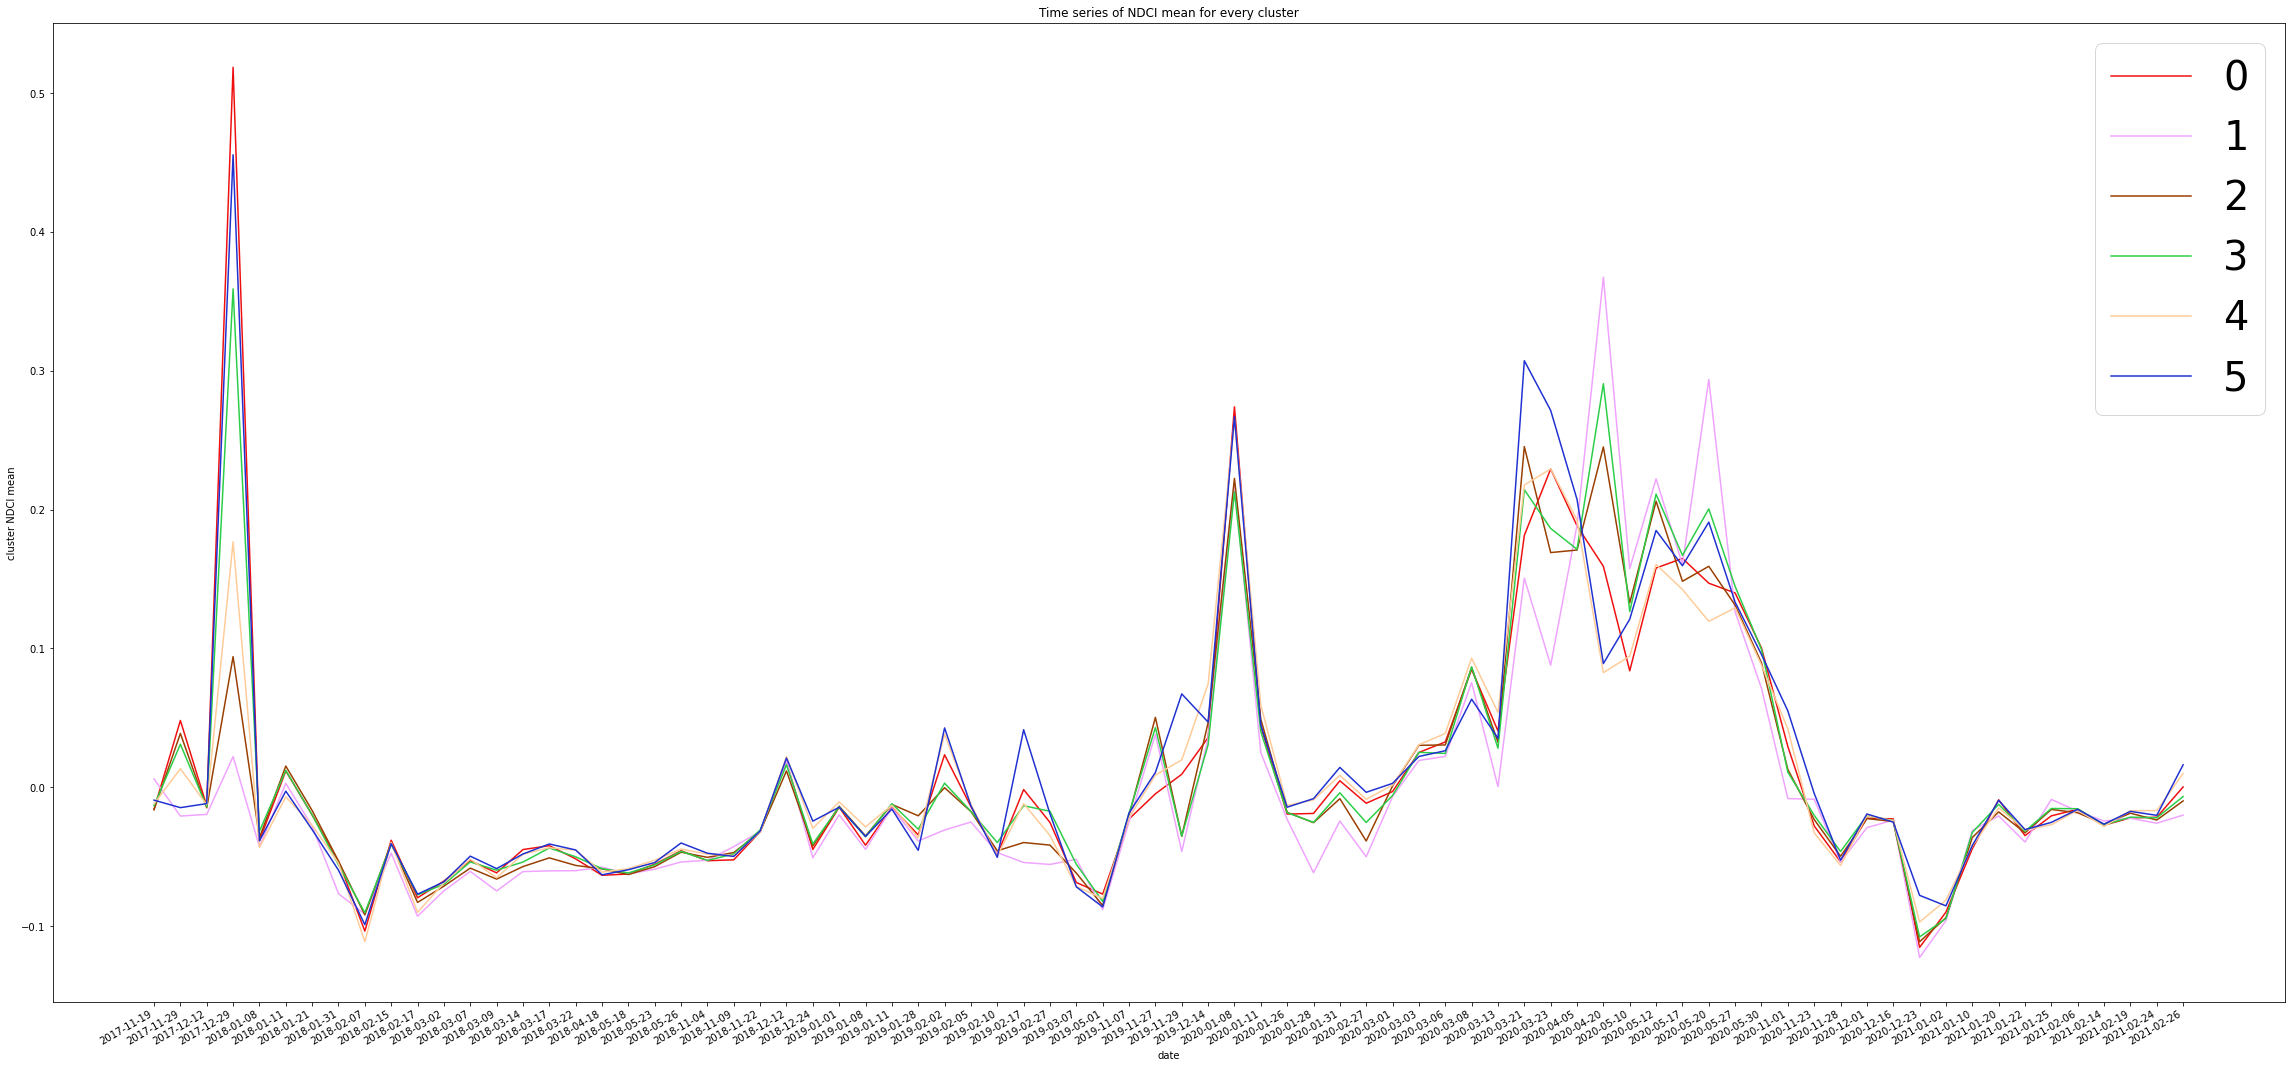

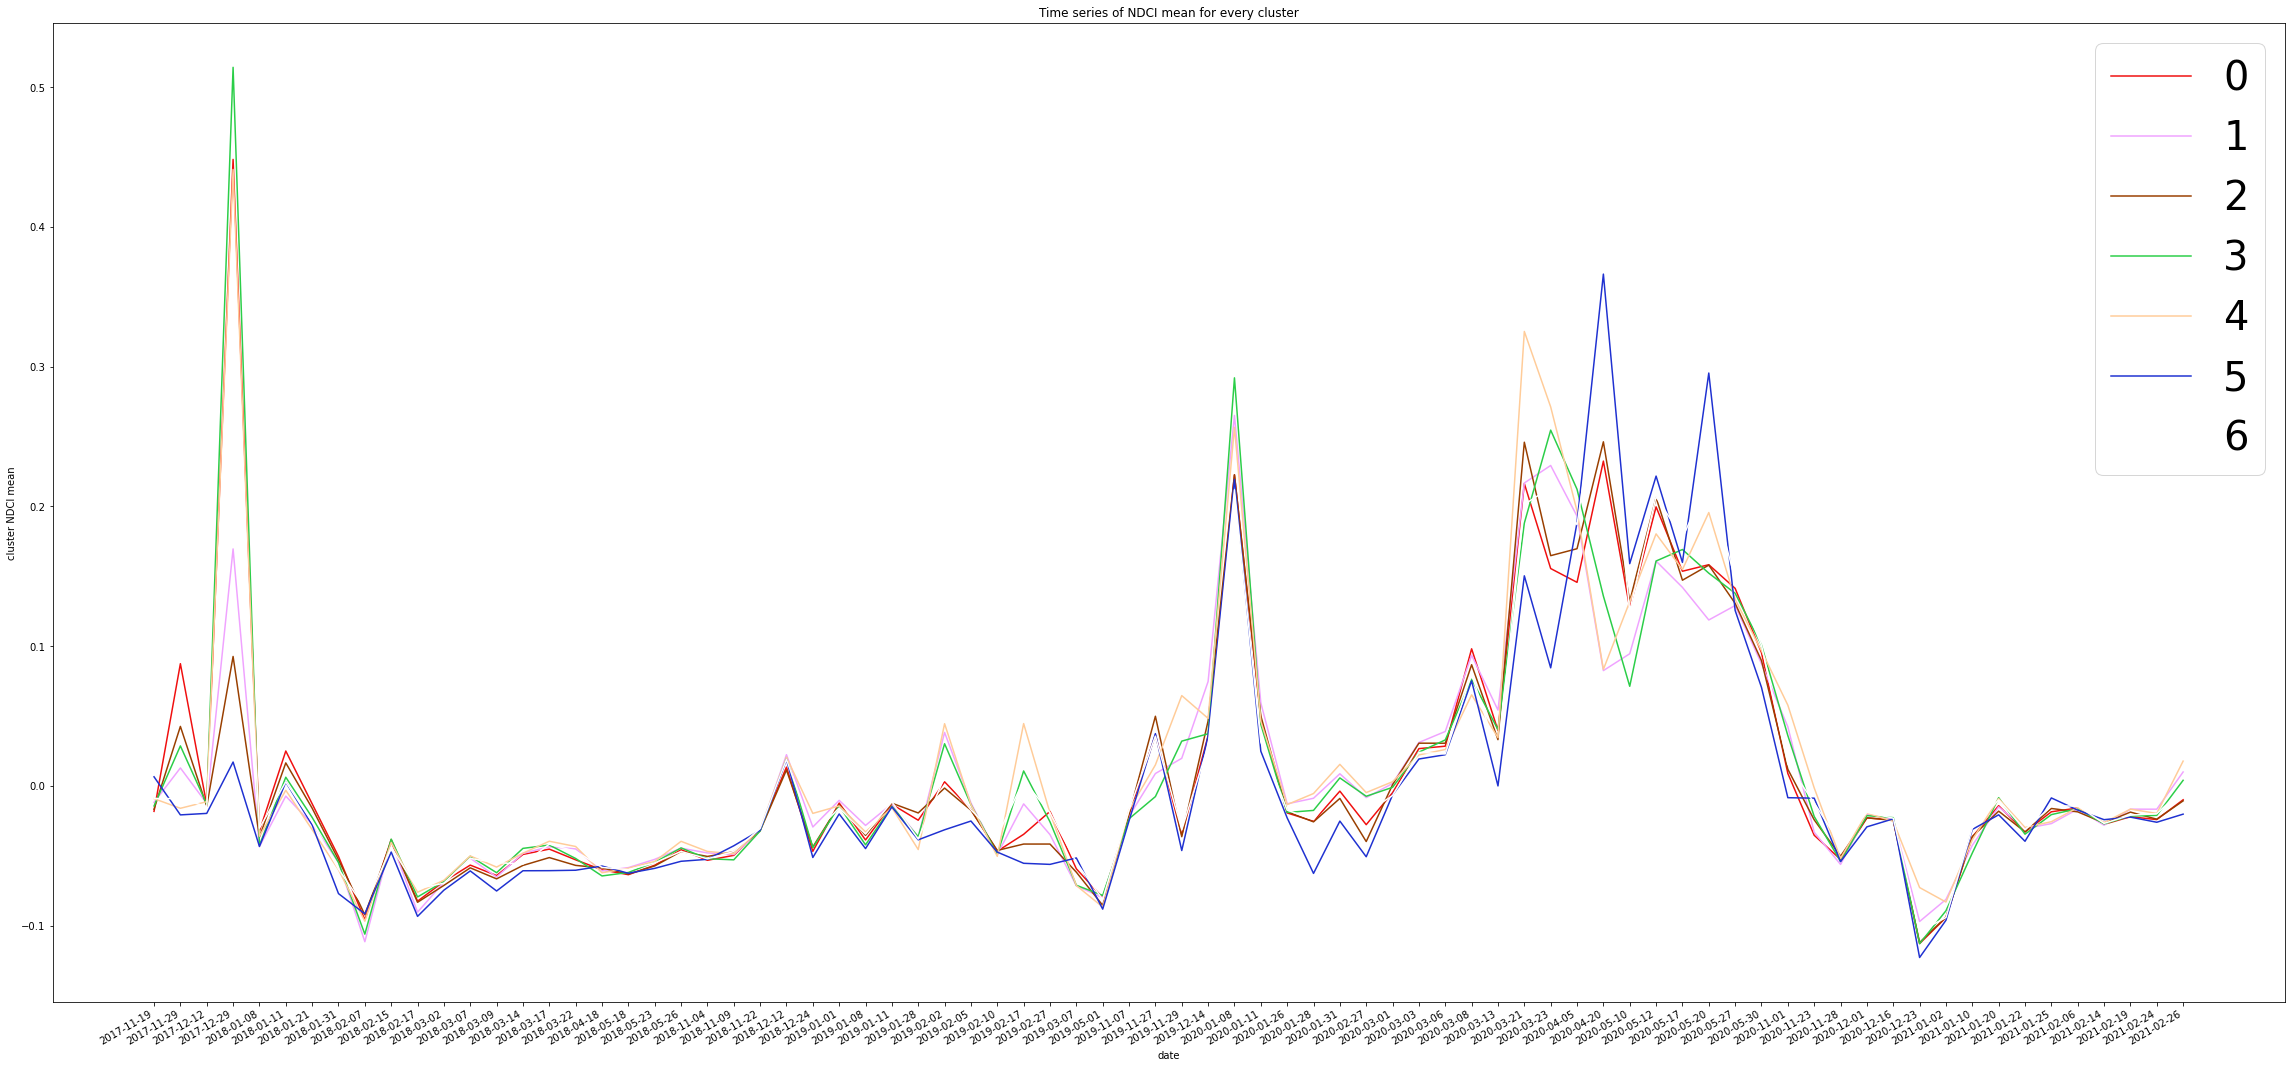

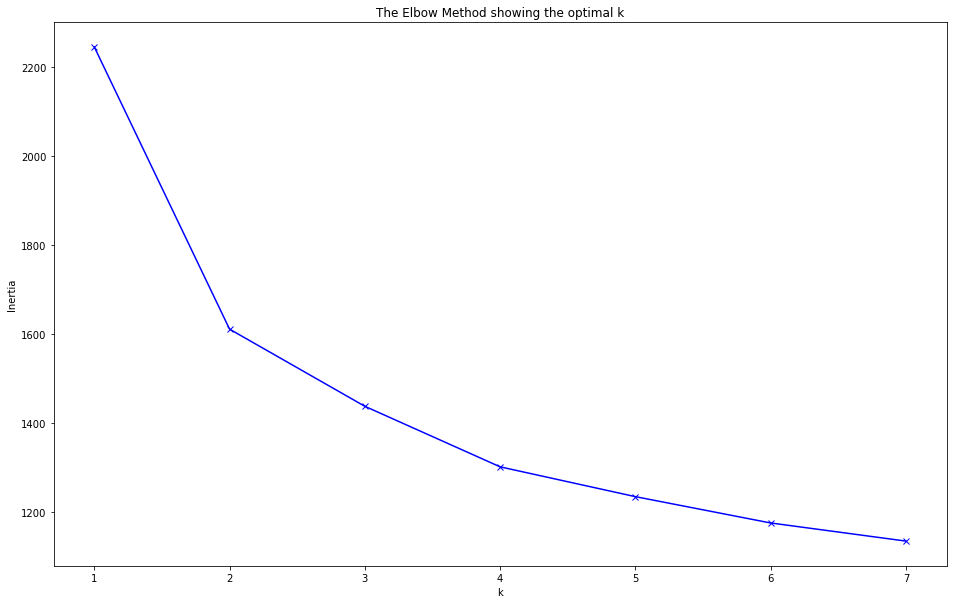

In [12]:
from sklearn.cluster import KMeans

def draw_text(text,img, x , y, color = (255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (110, 25)
    fontScale = 1
    thickness = 2
    cv2.putText(img, text, (x, y), font, 1, color, thickness, cv2.LINE_AA)


kmeans_save_path = "K-means"
    
inertias = []
K = range(1,8)
clusters_colors = [[240, 15, 15], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [255,255,255]]
pbar = tqdm(total=7)
for k in K:
    clustering = KMeans(n_clusters=k)
    clustering.fit(X)
    inertias.append(clustering.inertia_)
    
    sample_day = DayData(os.path.join("sample_data", "2021-01-25"))
    unique_labels = list(set(clustering.labels_))
                
    # load image without clusters
    final_img = sample_day.rgb.copy()
    labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254
    # itearte over a list containing the label of every pixel in the lagoon and paint it on map
    for i, label in enumerate(clustering.labels_):
        if label == -1:
            continue
        label_position = clustering_data["positions"][i]
        final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
        labels_arr[label_position[0], label_position[1]] = int(label)

    #draw legends
    legend_position = {"x": 50, "y": 50}
    for label in unique_labels:
        draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
        legend_position["y"] = legend_position["y"] + 50    

    # make and save map with clusters
    clusters_image_path = os.path.join(kmeans_save_path, str(k) + "_clusters.png")
    fig = plt.figure(figsize=(20,20))
    plt.imshow(final_img)
    plt.savefig(clusters_image_path, dpi=200, bbox_inches='tight')
    plt.close(fig)

    #get NDCI mean and std of every cluster in every day
    results = []
    for d in range(D):
        day_results = {}
        day_results["date"] = clustering_data["dates"][d]
        day_ndci = ndci_dataset_array[:, :, d]

        for label in unique_labels:
            y, x = np.where(labels_arr == label)
            label_ndci_values = []
            for i, j in zip(y, x):
                label_ndci_values.append(day_ndci[i, j])
            label_ndci_values = np.array(label_ndci_values)
            label_mean = np.mean(label_ndci_values)
            label_std = np.std(label_ndci_values)

            day_results[label] = {"mean": label_mean, "std": label_std}
        results.append(day_results)

    # make and save image with cluster mean time series
    day_indexes = range(1, len(results)+1)
    fig = plt.figure(figsize=(40,20))
    for i, label in enumerate(unique_labels):
        label_means = [d[label]["mean"] for d in results]
        #label_stds = [d[label]["std"] for d in results]
        #plt.plot(day_indexes, label_means, label=str(label) + " mean")
        color = tuple([c/255 for c in clusters_colors[label]])
        plt.plot([d["date"] for d in results], label_means, label=str(label), color=color)
        #plt.plot(day_indexes, label_stds, label=str(label) + " std")

    plt.xlabel('date')
    plt.xticks(np.arange(0, len(results), 1.0))
    # Set the y axis label of the current axis.
    plt.ylabel('cluster NDCI mean')
    # Set a title of the current axes.
    plt.title('Time series of NDCI mean for every cluster')
    # put date in angle to read better
    fig.autofmt_xdate()
    # show a legend on the plot
    plt.legend(prop={'size': 40})
    # save figure
    #timeseries_image_path = os.path.join(kmeans_save_path, str(k) + "_clusters_timeseries.png")
    #plt.savefig(timeseries_image_path, dpi=100, bbox_inches='tight')
    plt.close(fig)

    
    pbar.update(1)
pbar.close()
print(inertias)

inertias_image_path = os.path.join(kmeans_save_path, "inertias.png")
plt.figure(figsize=(16,10))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.savefig(inertias_image_path, dpi=100, bbox_inches='tight')
plt.show()

### Agglomerative clustering

In [14]:
linkage_methods = ["single", "complete", "average", "ward"]

metrics = ["euclidean", "cityblock", "cosine"]

Methods ‘centroid’, ‘median’, and ‘ward’ are correctly defined only if Euclidean pairwise metric is used.

In [66]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

def draw_text(text,img, x , y, color = (255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (110, 25)
    fontScale = 1
    thickness = 2
    cv2.putText(img, text, (x, y), font, 1, color, thickness, cv2.LINE_AA)

output_directory = "Agglomerative_clustering"
save_matrix = True
overwrite = False

sample_day = DayData(os.path.join("sample_data", "2021-01-25"))

clusters_colors = [[240, 15, 15], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [255,255,255]]

H, W, D = ndci_dataset_array.shape

for linkage_method in linkage_methods:
    for distance_metric in metrics:
        if linkage_method == "ward" and distance_metric != "euclidean":
            continue
        print("processing " + linkage_method + " linkage method with " + distance_metric + " metric")
        #create directory if doesn't exist already
        agglomerative_clustering_directory = os.path.join(output_directory, linkage_method, distance_metric)
        if not os.path.isdir(agglomerative_clustering_directory):
            os.makedirs(agglomerative_clustering_directory)
            
            # make linkage matrix or load if already stored
            try:
                linkage_matrix = np.load(os.path.join(agglomerative_clustering_directory, "linkage_matrix.npy"))

            except FileNotFoundError:
                linkage_matrix = sch.linkage(X, method=linkage_method, metric=distance_metric)
                if save_matrix == True:
                    np.save(os.path.join(agglomerative_clustering_directory, "linkage_matrix.npy"), linkage_matrix)

            # make and save dendogram
            fig = plt.figure(figsize=(20,13))
            dendrogram = sch.dendrogram(linkage_matrix, truncate_mode='level', p=3)
            plt.title(linkage_method + ' linkage dendrogram')
            plt.xlabel('Number of points in node')
            plt.ylabel(distance_metric + ' distances')
            plt.savefig(os.path.join(agglomerative_clustering_directory, "dendogram.jpg"))
            plt.close(fig)
            #plt.show()
            
            # process dataset for different amount of clusters and store things
            for n_clusters in [3, 4, 5, 6]:
                clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity=distance_metric, linkage=linkage_method).fit(X)
                unique_labels = list(set(clustering.labels_))
                
                #image without clusters
                final_img = sample_day.rgb.copy()
                labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254
                # itearte over a list containing the label of every pixel in the lagoon and paint it on map
                for i, label in enumerate(clustering.labels_):
                    if label == -1:
                        continue
                    label_position = clustering_data["positions"][i]
                    final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
                    labels_arr[label_position[0], label_position[1]] = int(label)
                    
                #draw legends
                legend_position = {"x": 50, "y": 50}
                for label in unique_labels:
                    draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
                    legend_position["y"] = legend_position["y"] + 50    

                # make and save map with clusters
                clusters_image_path = os.path.join(agglomerative_clustering_directory, str(n_clusters) + "_clusters.png")
                fig = plt.figure(figsize=(20,10))
                plt.imshow(final_img)
                plt.savefig(clusters_image_path, dpi=200, bbox_inches='tight')
                plt.close(fig)
                    
                #get NDCI mean and std of every cluster in every day
                results = []
                for d in range(D):
                    day_results = {}
                    day_results["date"] = clustering_data["dates"][d]
                    day_ndci = ndci_dataset_array[:, :, d]

                    for label in unique_labels:
                        y, x = np.where(labels_arr == label)
                        label_ndci_values = []
                        for i, j in zip(y, x):
                            label_ndci_values.append(day_ndci[i, j])
                        label_ndci_values = np.array(label_ndci_values)
                        label_mean = np.mean(label_ndci_values)
                        label_std = np.std(label_ndci_values)

                        day_results[label] = {"mean": label_mean, "std": label_std}
                    results.append(day_results)

                # make and save image with cluster mean time series
                day_indexes = range(1, len(results)+1)
                fig = plt.figure(figsize=(40,20))
                for label in unique_labels:
                    label_means = [d[label]["mean"] for d in results]
                    #label_stds = [d[label]["std"] for d in results]
                    #plt.plot(day_indexes, label_means, label=str(label) + " mean")
                    color = tuple([c/255 for c in clusters_colors[label]])
                    plt.plot([d["date"] for d in results], label_means, label=str(label), color=color)
                    #plt.plot(day_indexes, label_stds, label=str(label) + " std")
                    
                plt.xlabel('date')
                plt.xticks(np.arange(1, len(results)+1, 1.0))
                # Set the y axis label of the current axis.
                plt.ylabel('cluster NDCI mean')
                # Set a title of the current axes.
                plt.title('Time series of NDCI mean for every cluster')
                # put date in angle to read better
                fig.autofmt_xdate()
                # show a legend on the plot
                plt.legend(prop={'size': 40})
                # save figure
                timeseries_image_path = os.path.join(agglomerative_clustering_directory, str(n_clusters) + "_clusters_timeseries")
                plt.savefig(timeseries_image_path, dpi=100, bbox_inches='tight')
                plt.close(fig)

processing ward linkage method with euclidean metric
processing complete linkage method with euclidean metric
processing complete linkage method with cityblock metric
processing complete linkage method with cosine metric
processing single linkage method with euclidean metric
processing single linkage method with cityblock metric
processing single linkage method with cosine metric
processing average linkage method with euclidean metric
processing average linkage method with cityblock metric
processing average linkage method with cosine metric


### Spectral

In [64]:
from sklearn.cluster import SpectralClustering

def draw_text(text,img, x , y, color = (255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (110, 25)
    fontScale = 1
    thickness = 2
    cv2.putText(img, text, (x, y), font, 1, color, thickness, cv2.LINE_AA)


spectral_save_path = "Spectral"

K = range(3,7)
clusters_colors = [[240, 15, 15], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [255,255,255]]
pbar = tqdm(total=7)
for k in K:
    clustering = SpectralClustering(n_clusters=k)
    clustering.fit(X)
    
    sample_day = DayData(os.path.join("sample_data", "2021-01-25"))
    unique_labels = list(set(clustering.labels_))
    
    # load image without clusters
    final_img = sample_day.rgb.copy()
    labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254
    # itearte over a list containing the label of every pixel in the lagoon and paint it on map
    for i, label in enumerate(clustering.labels_):
        if label == -1:
            continue
        label_position = clustering_data["positions"][i]
        final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
        labels_arr[label_position[0], label_position[1]] = int(label)

    #draw legends
    legend_position = {"x": 50, "y": 50}
    for label in unique_labels:
        draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
        legend_position["y"] = legend_position["y"] + 50    

    # make and save map with clusters
    clusters_image_path = os.path.join(spectral_save_path, str(k) + "_clusters.png")
    fig = plt.figure(figsize=(20,20))
    plt.imshow(final_img)
    plt.savefig(clusters_image_path, dpi=200, bbox_inches='tight')
    plt.close(fig)

    #get NDCI mean and std of every cluster in every day
    results = []
    for d in range(D):
        day_results = {}
        day_results["date"] = clustering_data["dates"][d]
        day_ndci = ndci_dataset_array[:, :, d]

        for label in unique_labels:
            y, x = np.where(labels_arr == label)
            label_ndci_values = []
            for i, j in zip(y, x):
                label_ndci_values.append(day_ndci[i, j])
            label_ndci_values = np.array(label_ndci_values)
            label_mean = np.mean(label_ndci_values)
            label_std = np.std(label_ndci_values)

            day_results[label] = {"mean": label_mean, "std": label_std}
        results.append(day_results)

    # make and save image with cluster mean time series
    day_indexes = range(1, len(results)+1)
    fig = plt.figure(figsize=(40,20))
    for i, label in enumerate(unique_labels):
        label_means = [d[label]["mean"] for d in results]
        #label_stds = [d[label]["std"] for d in results]
        #plt.plot(day_indexes, label_means, label=str(label) + " mean")
        color = tuple([c/255 for c in clusters_colors[label]])
        plt.plot([d["date"] for d in results], label_means, label=str(label), color=color)
        #plt.plot(day_indexes, label_stds, label=str(label) + " std")

    plt.xlabel('date')
    plt.xticks(np.arange(0, len(results), 1.0))
    # Set the y axis label of the current axis.
    plt.ylabel('cluster NDCI mean')
    # Set a title of the current axes.
    plt.title('Time series of NDCI mean for every cluster')
    # put date in angle to read better
    fig.autofmt_xdate()
    # show a legend on the plot
    plt.legend(prop={'size': 40})
    # save figure
    timeseries_image_path = os.path.join(spectral_save_path, str(k) + "_clusters_timeseries.png")
    plt.savefig(timeseries_image_path, dpi=100, bbox_inches='tight')
    plt.close(fig)

    
    pbar.update(1)
pbar.close()

 57%|█████▋    | 4/7 [13:32<10:09, 203.09s/it]


### Choose clustering algorithm

In [26]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS

clustering = KMeans(n_clusters=1, random_state=0).fit(X)
#clustering = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward').fit(X)
#clustering = SpectralClustering(n_clusters=3, assign_labels='discretize').fit(X)
#clustering = OPTICS(min_samples=100).fit(X)

### Display dendogram

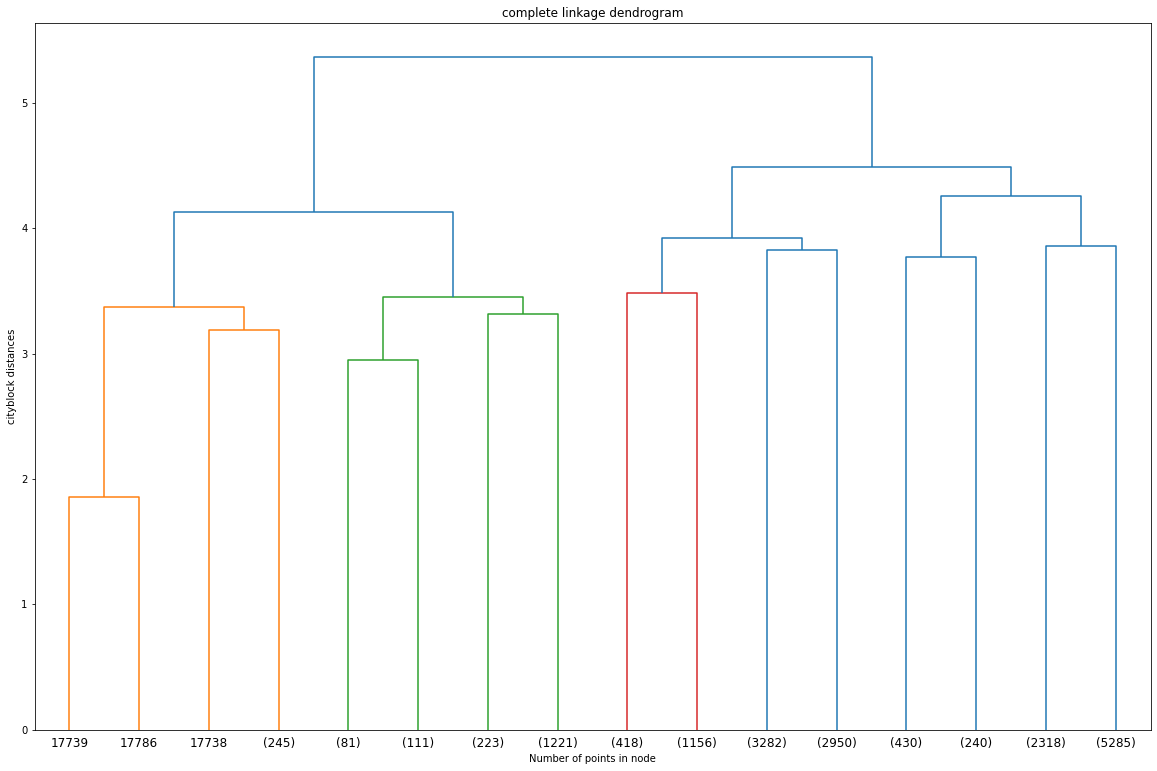

In [42]:
linkage_methods = ["ward", "complete", "single", "average"]
distance_metrics = ["euclidean", "cityblock", "cosine"]

linkage_method = linkage_methods[1]
distance_metric = distance_metrics[1]
linkage_matrix = sch.linkage(X, method=linkage_method, metric=distance_metric)

# make and save dendogram
fig = plt.figure(figsize=(20,13))
dendrogram = sch.dendrogram(linkage_matrix, truncate_mode='level', p=3)
plt.title(linkage_method + ' linkage dendrogram')
plt.xlabel('Number of points in node')
plt.ylabel(distance_metric + ' distances')
#plt.savefig(os.path.join(agglomerative_clustering_directory, "dendogram.jpg"))
#plt.close(fig)
plt.show()

### Display clusters

cluster labels: [0]


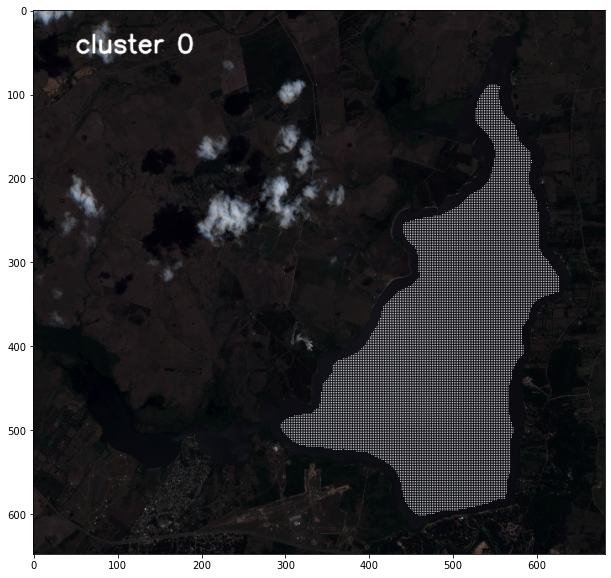

In [27]:
from process_sentinel2 import *
import random
import cv2

def draw_text(text,img, x , y, color = (255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (110, 25)
    fontScale = 1
    thickness = 2
    cv2.putText(img, text, (x, y), font, 1, color, thickness, cv2.LINE_AA)

sample_day = DayData(os.path.join("sample_data", "2021-01-25"))
final_img = sample_day.rgb.copy()
labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254


clusters_colors = [[255,255,255], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [0, 0, 0]]

unique_labels = list(set(clustering.labels_))
print("cluster labels:", unique_labels)

# here I'm iterating over a list containing the label of every pixel in the lagoon
for i, label in enumerate(clustering.labels_):
    if label == -1:
        continue
    label_position = clustering_data["positions"][i]
    final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
    labels_arr[label_position[0], label_position[1]] = int(label)

#draw legends
legend_position = {"x": 50, "y": 50}
for label in unique_labels:
    draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
    legend_position["y"] = legend_position["y"] + 50    

fig = plt.figure(figsize=(20,10))
plt.imshow(final_img)
#plt.savefig("test.png")
plt.show()

### Get mean and std of every cluster for every day

In [28]:
H, W, D = ndci_dataset_array.shape

results = []

pbar = tqdm(total=D)
for d in range(D):
    day_results = {}
    day_results["date"] = clustering_data["dates"][d]
    day_ndci = ndci_dataset_array[:, :, d]
    
    for label in unique_labels:
        y, x = np.where(labels_arr == label)
        label_ndci_values = []
        for i, j in zip(y, x):
            label_ndci_values.append(day_ndci[i, j])
        label_ndci_values = np.array(label_ndci_values)
        label_mean = np.mean(label_ndci_values)
        label_std = np.std(label_ndci_values)
        
        day_results[label] = {"mean": label_mean, "std": label_std}
    results.append(day_results)
    pbar.update(1)            
pbar.close()

100%|██████████| 78/78 [00:01<00:00, 57.66it/s]


# Visualization

### Load data from https://www.ambiente.gub.uy/oan/datos-abiertos/calidad-agua/

In [ ]:
import csv

def load_cyano_concentration_csv(csv_path):
    agua_data = {}
    with open(csv_path, newline='\n') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for i, row in enumerate(spamreader):
            if i==0:
                continue
            date_time = row[0][0:10]
            cyano_value = row[2]
            agua_data[date_time] = float(cyano_value)
    return agua_data

agua_data = load_cyano_concentration_csv("agua_open_data(1).csv")

### Time series of NDCI mean

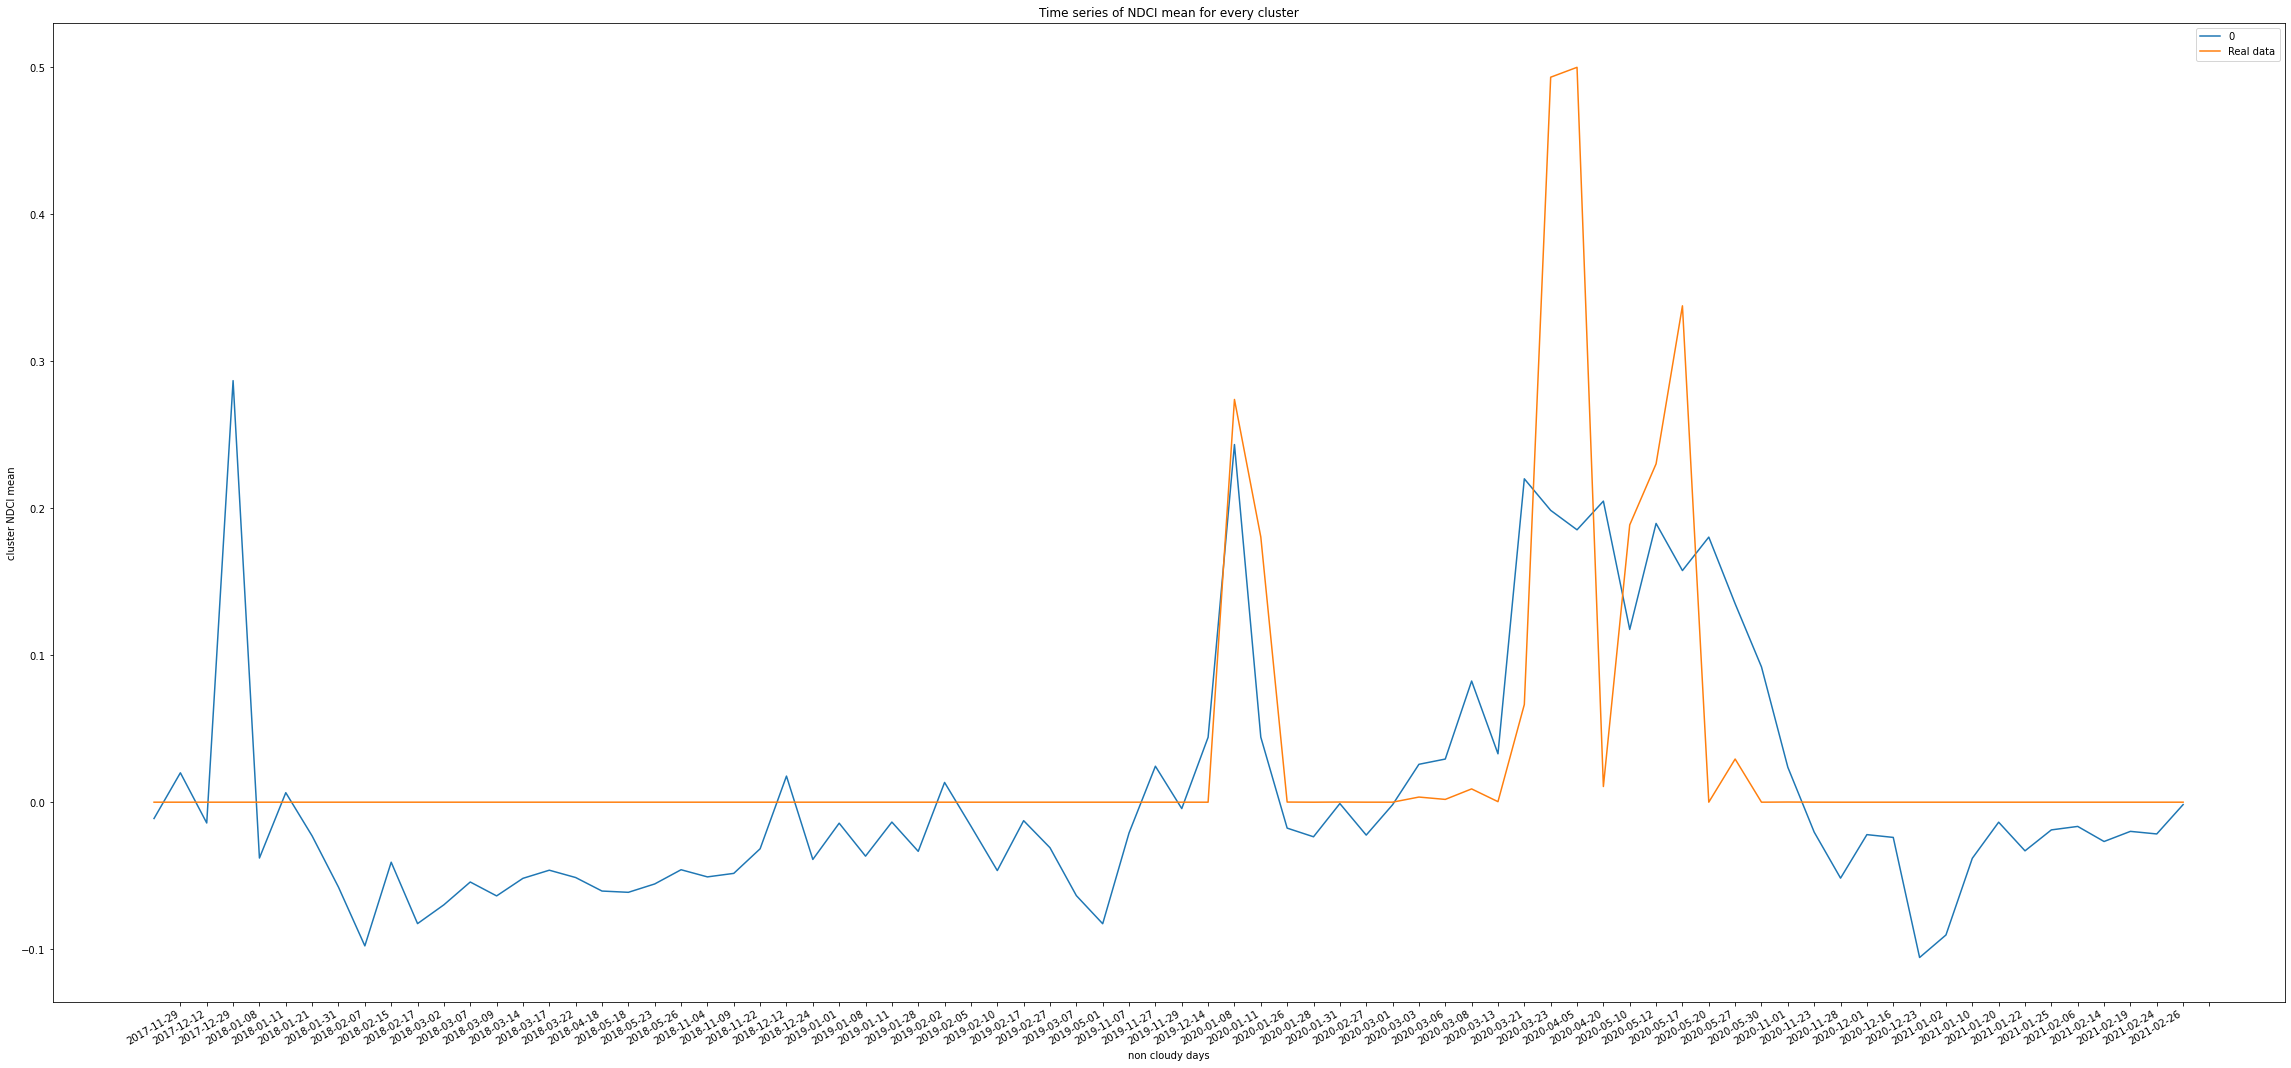

In [30]:
day_indexes = range(1, len(results)+1)
fig = plt.figure(figsize=(40,20))
for label in unique_labels:
    label_means = [d[label]["mean"] for d in results]
    #label_stds = [d[label]["std"] for d in results]
    #plt.plot(day_indexes, label_means, label=str(label) + " mean")
    plt.plot([d["date"] for d in results], label_means, label=str(label))
    #plt.plot(day_indexes, label_stds, label=str(label) + " std")

# plot results from ground truth
real_data_list = []
for d in results:
    try:
        day_real_data = agua_data[d["date"]]
    except:
        day_real_data = 0
    real_data_list.append(day_real_data)
real_data_list = np.array(real_data_list)
real_data_list /= np.max(np.abs(real_data_list),axis=0)
real_data_list = real_data_list*0.5
plt.plot([d["date"] for d in results], real_data_list, label="Real data")
    
plt.xlabel('non cloudy days')
plt.xticks(np.arange(1, len(results)+1, 1.0))
# Set the y axis label of the current axis.
plt.ylabel('cluster NDCI mean')
# Set a title of the current axes.
plt.title('Time series of NDCI mean for every cluster')
# put date in angle to read better
fig.autofmt_xdate()
# show a legend on the plot
plt.legend()
# save figure
plt.savefig("test3.png", dpi=100, bbox_inches='tight')
# Display a figure.
plt.show()
#plt.close(fig)

### Box plot

In [ ]:
import matplotlib.pyplot as plt

H, W, D = ndci_dataset_array.shape

results_box = []

pbar = tqdm(total=D)
for d in range(D):
    day_results = {}
    day_results["date"] = clustering_data["dates"][d]
    day_ndci = ndci_dataset_array[:, :, d]
    for label in unique_labels:
        y, x = np.where(labels_arr == label)
        label_ndci_values = []
        for i, j in zip(y, x):
            label_ndci_values.append(day_ndci[i, j])
        label_ndci_values = np.array(label_ndci_values)
        day_results[label] = label_ndci_values
    results_box.append(day_results)
    pbar.update(1)            
pbar.close()

for label in unique_labels:
    fig = plt.figure(figsize=(20,10))
    plt.title("Cluster " + str(label))
    boxplot_output = plt.boxplot([day[label] for day in results_box])
    plt.show()

### Visualize rgb from day in particular

2021-02-26


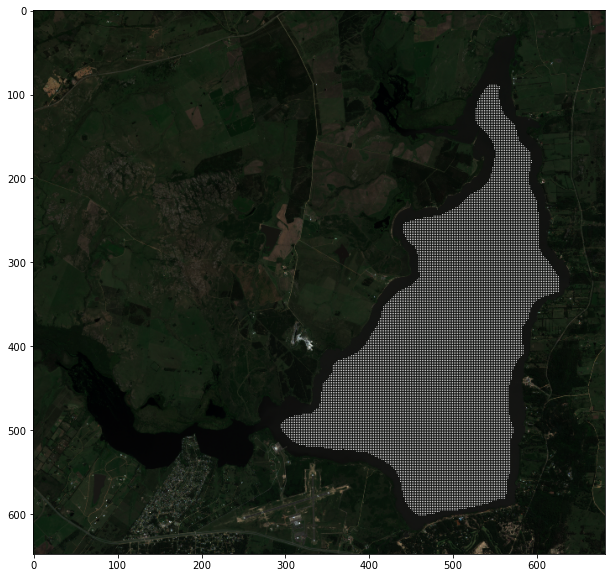

In [32]:
#DATE = "2021-01-25"
DATE = results[-1]["date"]
print(DATE)

day_data = DayData(os.path.join(settings.data_path, DATE, "acolite_output"))
fig = plt.figure(figsize=(20,10))
plt.imshow(day_data.rgb)
#plt.imshow(mask.display_mask_img(day_data.rgb))
plt.show()

### Compress directorys with results

In [ ]:
#!tar -zcvf K-means.tar.gz K-means
!tar -zcvf Agglomerative.tar.gz Agglomerative_clustering
#!tar -zcvf Spectral.tar.gz Spectral